In [1]:
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import tensorflow as tf
from models.unetResidual import UnetResidual
from models.unet import Unet

In [2]:
#model_file_name = 'unet-residual-dice.h5'
model_file_name = 'unet-baseline.h5'
model_name = 'foo'
image_size = (256, 256)
#unet_residual = UnetResidual(model_name, image_size, version=1)
unet_residual = Unet(model_name, image_size, version=1)
unet_residual.restore(model_file_name)

In [3]:
def display_prediction_result(x_test, y_pred):
    plt.figure(figsize=(24, 5))
    plt.subplot(1, 4, 1)
    plt.imshow(x_test)
    plt.subplot(1, 4, 2)
    plt.imshow(y_pred.squeeze(), cmap='gray')
    plt.show()
    plt.close()
    
def mean_iou(y_true, y_pred):
    yt0 = y_true[:, :, :, 0]
    yp0 = tf.keras.backend.cast(y_pred[:, :, :, 0] > 0.5, 'float32')
    inter = tf.math.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    union = tf.math.count_nonzero(tf.add(yt0, yp0))
    iou = tf.where(tf.equal(union, 0), 1.0, tf.cast(inter/union, 'float32'))
    return iou
    
def get_pred(x, y, model):
    #predict the mask 
    pred1 = model.predict(np.expand_dims(x, 0))
    msk = pred1.squeeze()
    # return the prediction and the IOU score of the prediction
    return msk#, mean_iou(y, msk)

Display a list of the layers in the model.

In [4]:
unet_residual.get_model_summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 8)  224         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 8)  584         conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 8)  0           conv2d_1[0][0]                   
_______________________________________________________________________________________

Test the model against unseen data.

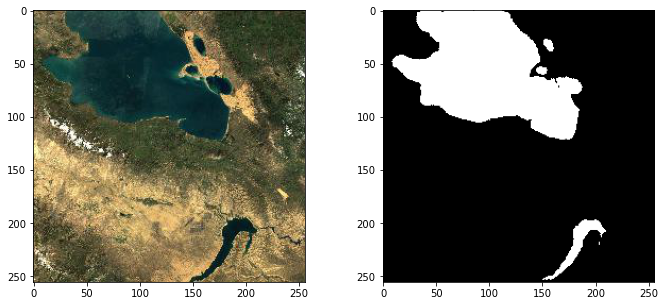

In [8]:
image_path = 's2cloudless_imagery/data/turkey_salda_s2cloudless_2018.jpg'
image_path = 's2cloudless_imagery/data/bulgaria_batak_s2cloudless_2017.jpg'
image_path = 's2cloudless_imagery/data/china_qinghai_s2cloudless_2016.jpg'

#image_path = 'nwpu_images/data/lake_006.jpg'
#image_path = 'nwpu_images/data/lake_106.jpg'
#image_path = 'nwpu_images/data/lake_206.jpg'
#image_path = 'nwpu_images/data/lake_406.jpg'

with rasterio.open(image_path) as dataset:
    bands = dataset.read()
    raw_image = np.ma.transpose(bands, [1, 2, 0])
    original_image = tf.Variable(raw_image)
    resized_image = tf.keras.preprocessing.image.smart_resize(original_image, image_size)
    y_pred = unet_residual.predict(np.expand_dims(resized_image, axis=0))
    display_prediction_result(raw_image, y_pred)
    #ypred = get_pred(raw_image, y_pred, unet_residual)
    #iou = mean_iou(np.expand_dims(np.expand_dims(ypred, axis=0), axis=0), np.expand_dims(np.atleast_3d(ypred), axis=0)).numpy()
    #print("IoU: {}".format(iou))